<a href="https://colab.research.google.com/github/JakubMarac/real_estate_poznan_analysis/blob/main/real_estate_pzn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from statsmodels.nonparametric.smoothers_lowess import lowess

import matplotlib.ticker as mtick
plt.style.use("seaborn-v0_8-whitegrid")

In [79]:
# Wczytanie danych
path = "/content/data/rent-poznan.xlsx"
df = pd.read_excel(path)

In [48]:
df.head()

,id,date_activ,date_modif,date_expire,individual,price,flat_area,flat_rooms,flat_floor_no,flat_build_year,...,flat_internet,flat_television,flat_phone,flat_anti_blinds,flat_anti_doors_windows,flat_intercom,flat_monitoring,flat_alarm_sys,flat_closed_area,quarter
0,19576742,2015-03-24,2020-09-05,2020-10-05,True,1400,30.0,1,2.0,0,...,False,False,False,False,False,True,False,False,False,Rataje
1,20292499,2013-07-19,2020-08-30,2020-09-09,True,4600,160.0,4,4.0,1900,...,True,True,True,False,False,True,True,True,False,Stare Miasto
2,25876297,2014-04-05,2019-09-10,2019-09-30,True,2300,54.0,3,1.0,2009,...,True,True,False,True,True,True,True,False,True,Centrum
3,30574847,2014-08-10,2020-03-03,2020-03-10,True,1600,49.0,2,5.0,0,...,False,False,False,False,True,True,False,False,False,Górna Wilda
4,30774505,2014-08-17,2019-11-15,2019-12-15,True,1200,32.5,1,3.0,2000,...,False,False,False,False,False,True,True,False,False,Rataje


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16448 entries, 0 to 16447
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       16448 non-null  int64         
 1   date_activ               16448 non-null  datetime64[ns]
 2   date_modif               16448 non-null  datetime64[ns]
 3   date_expire              16448 non-null  datetime64[ns]
 4   individual               16448 non-null  bool          
 5   price                    16448 non-null  int64         
 6   flat_area                16448 non-null  float64       
 7   flat_rooms               16448 non-null  int64         
 8   flat_floor_no            15775 non-null  float64       
 9   flat_build_year          16448 non-null  int64         
 10  flat_furnished           16448 non-null  bool          
 11  flat_rent                16448 non-null  int64         
 12  flat_deposit             16448 n

In [50]:
# Liczba braków w kolumnach
missing = df.isna().sum().sort_values(ascending=False)

print("Braki danych (liczba NA) w kolumnach:")
print(missing[missing > 0])

Braki danych (liczba NA) w kolumnach:
building_material    7530
flat_status          5086
flat_windows         4768
flat_heating         4148
building_type        2702
flat_floor_no         673
dtype: int64


In [51]:
# liczba obserwacji
n = len(df)

missing = df.isna().sum()
missing_pct = (missing / n) * 100

# tylko kolumny z brakami
missing_df = (
    pd.DataFrame({
        "Liczba braków": missing,
        "Procent braków": missing_pct
    })
    .query("`Liczba braków` > 0")
    .sort_values("Liczba braków", ascending=False)
)

In [53]:
# Procent braków
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

print("\nBraki danych (%):")
print(missing_pct[missing_pct > 0].round(2))


Braki danych (%):
building_material    45.78
flat_status          30.92
flat_windows         28.99
flat_heating         25.22
building_type        16.43
flat_floor_no         4.09
dtype: float64


In [55]:
df_clean = df.dropna(subset=[
    "price",
    "flat_area",
    "quarter",
    "building_material",
    "flat_status",
    "flat_windows",
    "flat_heating",
    "building_type",
    "flat_floor_no"
]).copy()

In [56]:
#  po wczytaniu i podstawowym czyszczeniu---
df_base = df_clean.copy()

# nowa zmienna
df_base["price_per_m2"] = df_base["price"] / df_base["flat_area"]

# Filtr 99%
p_m2_low, p_m2_high = df_base["price_per_m2"].quantile([0.005, 0.995])
p_price_low, p_price_high = df_base["price"].quantile([0.005, 0.995])
p_area_low, p_area_high = df_base["flat_area"].quantile([0.005, 0.995])

df_99 = df_base[
    df_base["price_per_m2"].between(p_m2_low, p_m2_high) &
    df_base["price"].between(p_price_low, p_price_high) &
    df_base["flat_area"].between(p_area_low, p_area_high)
].copy()


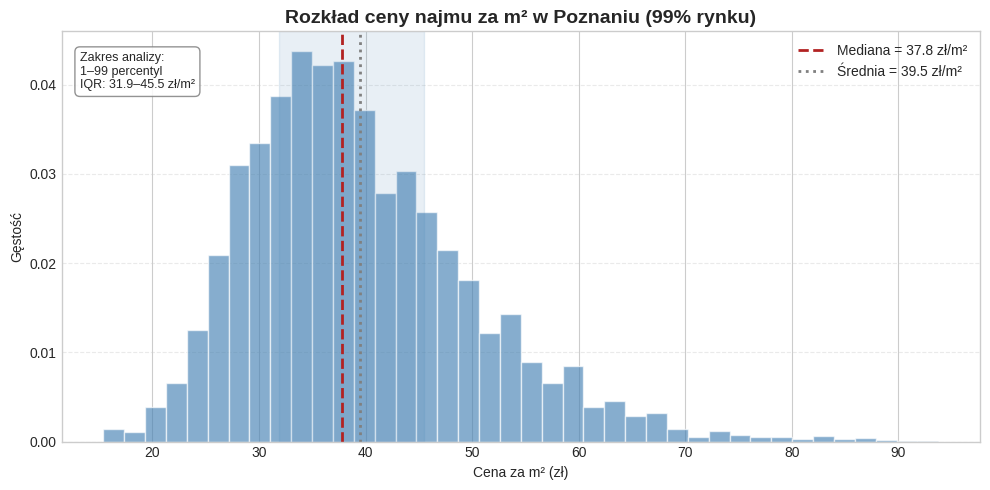

In [57]:

# Przygotowanie danych
price_m2 = df_99["price_per_m2"]

# IQR (25–75%)
q25, q75 = price_m2.quantile([0.25, 0.75])

# statystyki
median = price_m2.median()
mean = price_m2.mean()

# Wykres
fig, ax = plt.subplots(figsize=(10, 5))

# histogram
ax.hist(
    price_m2,
    bins=40,
    density=True,
    color="steelblue",
    alpha=0.65,
    edgecolor="white"
)

# IQR (25–75%)
ax.axvspan(
    q25, q75,
    color="steelblue",
    alpha=0.12
)

# linie statystyczne
ax.axvline(
    median,
    color="firebrick",
    linestyle="--",
    linewidth=2,
    label=f"Mediana = {median:.1f} zł/m²"
)

ax.axvline(
    mean,
    color="gray",
    linestyle=":",
    linewidth=2,
    label=f"Średnia = {mean:.1f} zł/m²"
)

# tytuły i opisy
ax.set_title(
    "Rozkład ceny najmu za m² w Poznaniu (99% rynku)",
    fontsize=14,
    weight="bold"
)
ax.set_xlabel("Cena za m² (zł)")
ax.set_ylabel("Gęstość")

# siatka
ax.grid(axis="y", linestyle="--", alpha=0.4)

# legenda
ax.legend(loc="upper right", frameon=False)

# ramka metodologiczna
ax.text(
    0.02, 0.95,
    "Zakres analizy:\n"
    "1–99 percentyl\n"
    f"IQR: {q25:.1f}–{q75:.1f} zł/m²",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=9,
    bbox=dict(
        boxstyle="round,pad=0.4",
        facecolor="white",
        edgecolor="gray",
        alpha=0.85
    )
)

plt.tight_layout()
plt.show()

In [ ]:
# Wykres przedstawia rozkład cen najmu za metr kwadratowy mieszkań w Poznaniu po ograniczeniu danych do
# zakresu 1–99 percentyla, co pozwala wyeliminować wpływ obserwacji skrajnych.
# Rozkład ma wyraźną prawostronną asymetrię – większość ofert koncentruje się w przedziale około 30–45 zł/m²,
# natomiast wyższe ceny występują rzadziej, tworząc długi prawy ogon rozkładu.
# Mediana ceny najmu wynosi 37,8 zł/m² i jest niższa od średniej (39,5 zł/m²),
# co wskazuje na obecność relatywnie drogich ofert podnoszących średnią wartość.
# Zaznaczony zakres międzykwartylowy (IQR: 31,9–45,5 zł/m²) obrazuje typowy przedział cen,
# w którym znajduje się środkowe 50% obserwacji rynkowych.

In [58]:
# --- GRUPOWANIE DZIELNIC (TOP 8 + Inne) ---
top_quarters = (
    df_99["quarter"]
    .value_counts()
    .nlargest(8)
    .index
)

df_99 = df_99.copy()
df_99["quarter_grouped"] = df_99["quarter"].where(
    df_99["quarter"].isin(top_quarters),
    "Inne"
)

/tmp/ipython-input-881392466.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues")
/tmp/ipython-input-881392466.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


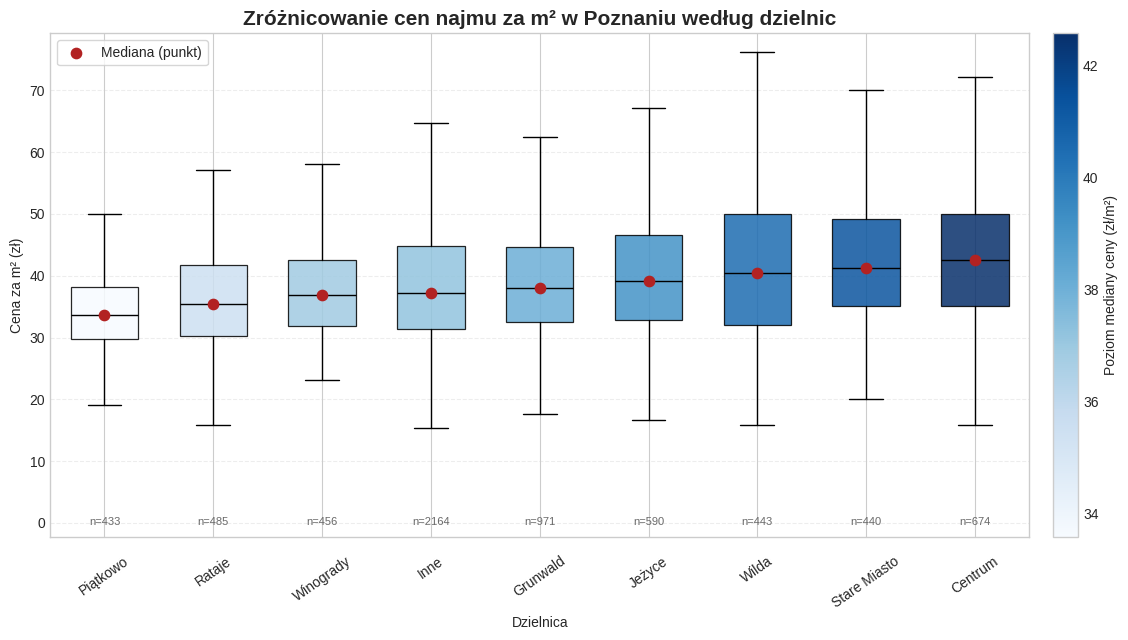

In [69]:

# WYKRES 2: Cena za m² vs dzielnica

# Top 8 dzielnic + "Inne"
top_quarters = df_99["quarter"].value_counts().nlargest(8).index
df_99["quarter_grouped"] = np.where(df_99["quarter"].isin(top_quarters), df_99["quarter"], "Inne")

# Kolejność wg mediany
order = (
    df_99.groupby("quarter_grouped")["price_per_m2"]
    .median()
    .sort_values()
    .index
    .tolist()
)

# Dane i statystyki
groups = [df_99.loc[df_99["quarter_grouped"] == q, "price_per_m2"].values for q in order]
counts = [len(g) for g in groups]
medians = [np.median(g) if len(g) else np.nan for g in groups]

# Kolory boxów wg mediany
norm = mcolors.Normalize(vmin=np.nanmin(medians), vmax=np.nanmax(medians))
cmap = cm.get_cmap("Blues")
box_colors = [cmap(norm(m)) for m in medians]

# Rysunek
fig, ax = plt.subplots(figsize=(12.5, 6.5))

bp = ax.boxplot(
    groups,
    labels=order,
    showfliers=False,
    patch_artist=True,
    widths=0.62
)

for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor("black")
    patch.set_linewidth(0.9)
    patch.set_alpha(0.85)

for element in ["whiskers", "caps", "medians"]:
    for line in bp[element]:
        line.set_color("black")
        line.set_linewidth(1.0)


xpos = np.arange(1, len(order) + 1)
ax.scatter(xpos, medians, s=55, color="firebrick", zorder=3, label="Mediana (punkt)")

# Etykiety osi X + miejsce na n=...
ax.tick_params(axis="x", rotation=35, pad=12)

ymin, ymax = ax.get_ylim()
y_range = ymax - ymin

extra_bottom = 0.22 * y_range
ax.set_ylim(ymin - extra_bottom, ymax)

ymin2, ymax2 = ax.get_ylim()
y_range2 = ymax2 - ymin2
y_text = ymin2 + 0.02 * y_range2

for x, n in zip(xpos, counts):
    ax.text(x, y_text, f"n={n}", ha="center", va="bottom", fontsize=8, color="dimgray")

# Tytuły / osie / siatka
ax.set_title("Zróżnicowanie cen najmu za m² w Poznaniu według dzielnic", fontsize=15, weight="bold")
ax.set_ylabel("Cena za m² (zł)")
ax.set_xlabel("Dzielnica")

ax.grid(axis="y", linestyle="--", alpha=0.35)
ax.set_axisbelow(True)

#  Colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Poziom mediany ceny (zł/m²)")

ax.legend(loc="upper left", frameon=True)

# Marginesy
plt.subplots_adjust(bottom=0.22)
plt.tight_layout()
plt.show()


In [ ]:
# Wykres pudełkowy przedstawia rozkład cen najmu za metr kwadratowy w poszczególnych dzielnicach Poznania.
# Widoczne jest istotne zróżnicowanie cen pomiędzy dzielnicami, co potwierdza znaczenie lokalizacji na
# rynku najmu. Najniższe mediany cen występują w dzielnicach peryferyjnych (np. Piątkowo, Rataje),
# natomiast najwyższe w Centrum i na Starym Mieście. Dzielnice centralne cechują się również większą
# zmiennością cen, wskazując na zróżnicowany standard ofert.

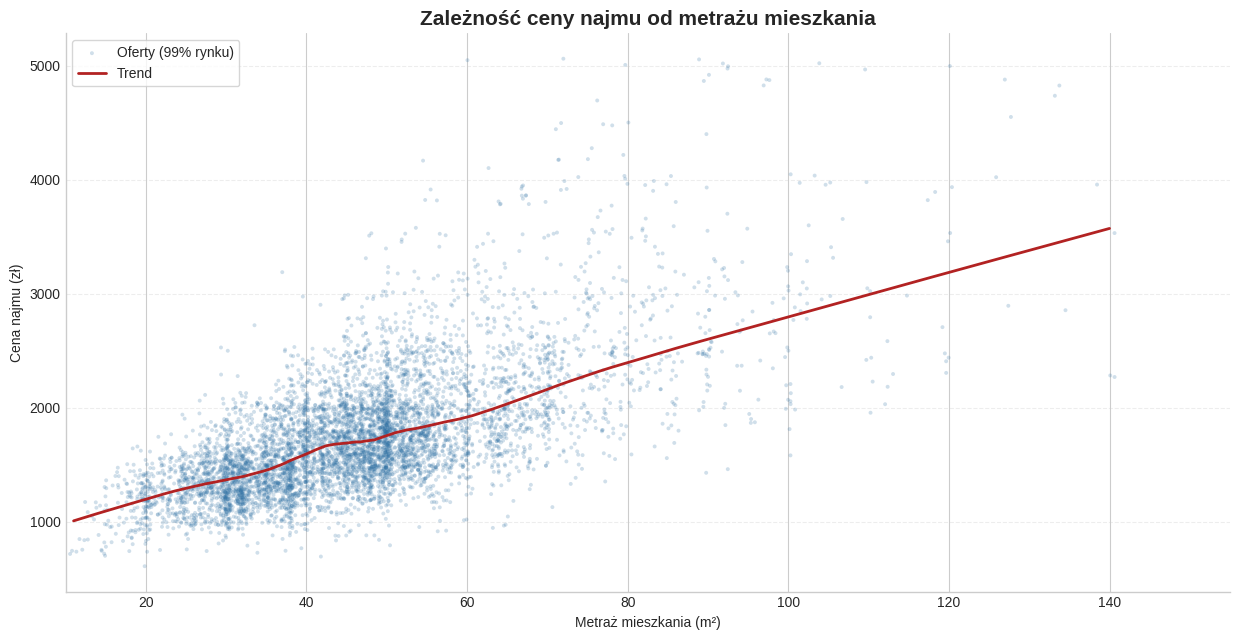

In [63]:


# =========================
#  WYKRES Cena najmu vs metraż mieszkania
# - zakres metrażu: od 10 m² do 150 m²
# - 99% rynku
# =========================


# Mikro-jitter
rng = np.random.default_rng(42)
x_jitter = df_99["flat_area"] + rng.normal(0, 0.35, size=len(df_99))
y_jitter = df_99["price"] + rng.normal(0, 40, size=len(df_99))

# LOWESS
lowess_curve = lowess(
    df_99["price"],
    df_99["flat_area"],
    frac=0.25,
    return_sorted=True
)

# Wykres
fig, ax = plt.subplots(figsize=(12.5, 6.5))

ax.scatter(
    x_jitter,
    y_jitter,
    s=8,
    alpha=0.22,
    color="#2C6FA3",
    edgecolors="none",
    label="Oferty (99% rynku)"
)

# linia trendu
ax.plot(
    lowess_curve[:, 0],
    lowess_curve[:, 1],
    color="firebrick",
    linewidth=2,
    label="Trend"
)

# Opisy
ax.set_title(
    "Zależność ceny najmu od metrażu mieszkania",
    fontsize=15,
    weight="bold"
)
ax.set_xlabel("Metraż mieszkania (m²)")
ax.set_ylabel("Cena najmu (zł)")

ax.grid(axis="y", linestyle="--", alpha=0.35)
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim(10, 155)
ax.legend(loc="upper left", frameon=True)

plt.tight_layout()
plt.show()


In [ ]:
# Wykres punktowy przedstawia zależność całkowitej ceny najmu od metrażu mieszkania w Poznaniu dla 99% rynku.
# Widoczna jest dodatnia zależność – wraz ze wzrostem powierzchni mieszkania rośnie cena najmu.
# Jednocześnie wraz z metrażem zwiększa się rozrzut cen, co wskazuje na większe zróżnicowanie standardu
#  i lokalizacji większych mieszkań. Linia trendu podkreśla ogólną tendencję wzrostową pomimo znacznej
#  zmienności pojedynczych ofert.

In [86]:
# city_median = df_99["price_per_m2"].median()
# ax.axhline(city_median, color="firebrick", linestyle="--", linewidth=1)

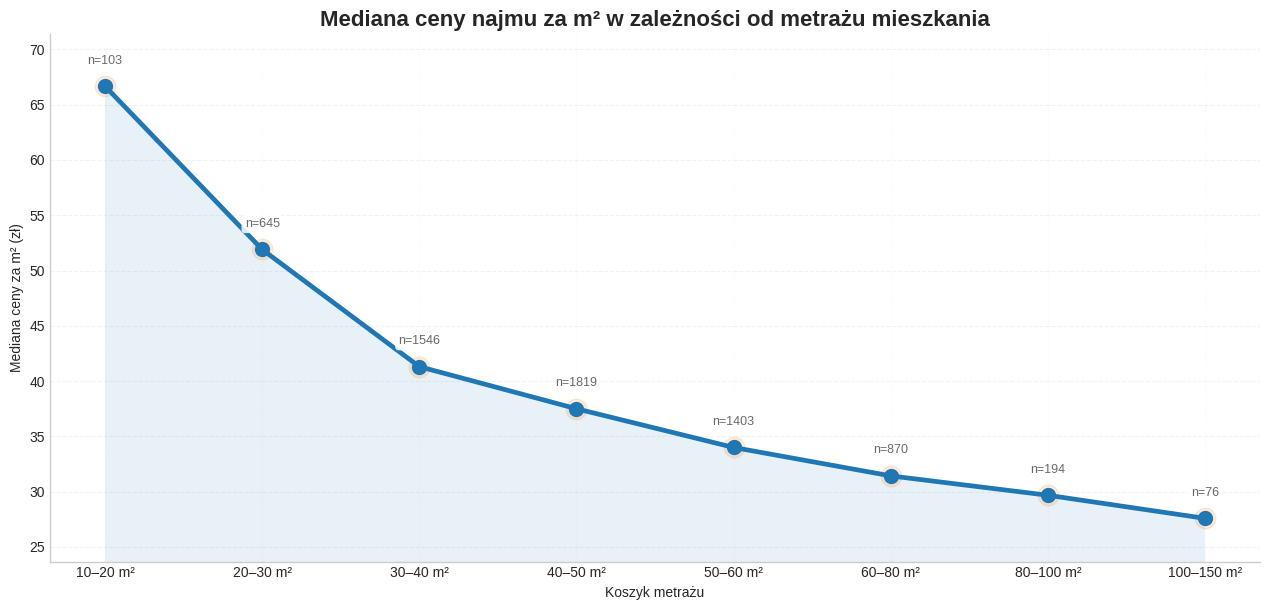

In [87]:
AREA_BINS = [10, 20, 30, 40, 50, 60, 80, 100, 150]
AREA_LABELS = ["10–20 m²","20–30 m²","30–40 m²","40–50 m²","50–60 m²","60–80 m²","80–100 m²","100–150 m²"]

df_plot = df_99.copy()

df_plot["area_bin"] = pd.cut(
    df_plot["flat_area"],
    bins=AREA_BINS,
    labels=AREA_LABELS,
    include_lowest=True,
    right=False
)

area_stats = (
    df_plot
    .dropna(subset=["area_bin"])
    .groupby("area_bin", observed=True)["price_per_m2"]
    .agg(median="median", n="size")
    .reindex(AREA_LABELS)
)

x = np.arange(len(area_stats.index))
y = area_stats["median"].values.astype(float)
n = area_stats["n"].values.astype(int)

fig, ax = plt.subplots(figsize=(12.8, 6.2))

ax.fill_between(x, y, y2=np.nanmin(y) - 5, alpha=0.10)

# linia + markery
ax.plot(x, y, linewidth=3.4, marker="o", markersize=10)
ax.scatter(x, y, s=220, alpha=0.14)  # halo


y_range = np.nanmax(y) - np.nanmin(y)
y_offset = 0.05 * y_range

for xi, yi, ni in zip(x, y, n):
    if np.isfinite(yi):
        ax.annotate(
            f"n={ni}",
            (xi, yi),
            xytext=(0, 14),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
            color="dimgray",
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.85)
        )

# tytuł + podtytuł
ax.set_title("Mediana ceny najmu za m² w zależności od metrażu mieszkania", fontsize=16, weight="bold")


ax.set_xlabel("Koszyk metrażu")
ax.set_ylabel("Mediana ceny za m² (zł)")

# oś X
ax.set_xticks(x)
ax.set_xticklabels(area_stats.index)

ax.yaxis.set_major_locator(mtick.MultipleLocator(5))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

ax.grid(axis="y", linestyle="--", alpha=0.25)
ax.grid(axis="x", linestyle=":", alpha=0.12)
ax.set_axisbelow(True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_ylim(np.nanmin(y) - 0.10 * y_range, np.nanmax(y) + 0.12 * y_range)

plt.tight_layout()
plt.show()


In [ ]:
# Wykres przedstawia medianę ceny najmu za metr kwadratowy w zależności od metrażu mieszkania,
# z wykorzystaniem koszyków powierzchniowych. Widoczny jest wyraźny spadek ceny za m² wraz ze wzrostem metrażu
# lokalu. Najwyższe ceny jednostkowe dotyczą najmniejszych mieszkań (10–20 m²), natomiast największe
# lokale charakteryzują się najniższą medianą ceny za m². Zjawisko to wskazuje na efekt skali,
# zgodnie z którym większe mieszkania są relatywnie tańsze w przeliczeniu na jednostkę powierzchni.